##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pose Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect pose landmarks from images.

## Preparation

Let's start with installing MediaPipe.


In [1]:
!pip install -q mediapipe


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [3]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## Visualization utilities

In [14]:
import numpy as np
from mediapipe.tasks.python.vision import drawing_utils
from mediapipe.tasks.python.vision import drawing_styles
from mediapipe.tasks.python import vision


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks

  if rgb_image.ndim != 3:
    raise ValueError("Input image must be an HxWxC array")

  if rgb_image.shape[2] == 4:
    rgb_image = rgb_image[:, :, :3]
  elif rgb_image.shape[2] == 1:
    rgb_image = np.repeat(rgb_image, 3, axis=2)

  if rgb_image.shape[2] != 3:
    raise ValueError("Input image must have 3 channels after preprocessing")

  # MediaPipe drawing_utils expects a 3-channel BGR image.
  annotated_image_bgr = np.ascontiguousarray(rgb_image[:, :, ::-1])

  pose_landmark_style = drawing_styles.get_default_pose_landmarks_style()
  pose_connection_style = drawing_utils.DrawingSpec(color=(0, 255, 0), thickness=2)

  for pose_landmarks in pose_landmarks_list:
    drawing_utils.draw_landmarks(
        image=annotated_image_bgr,
        landmark_list=pose_landmarks,
        connections=vision.PoseLandmarksConnections.POSE_LANDMARKS,
        landmark_drawing_spec=pose_landmark_style,
        connection_drawing_spec=pose_connection_style)

  # Convert back to RGB for notebook visualization.
  return annotated_image_bgr[:, :, ::-1]

## Download test image

To demonstrate the Pose Landmarker API, you can download a sample image using the follow code. The image is from [Pixabay](https://pixabay.com/photos/girl-woman-fitness-beautiful-smile-4051811/).

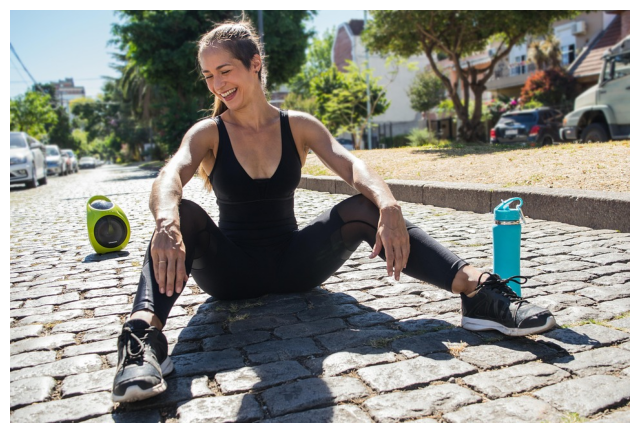

In [10]:
import urllib.request
import cv2
import matplotlib.pyplot as plt

url = "https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg"
request = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
with urllib.request.urlopen(request) as response, open("image.jpg", "wb") as f:
    f.write(response.read())

img = cv2.imread("image.jpg")
if img is None:
    raise ValueError("Failed to load image.jpg")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


I0000 00:00:1771522299.293639 3121872 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
W0000 00:00:1771522299.368686 3121874 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1771522299.389017 3121879 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


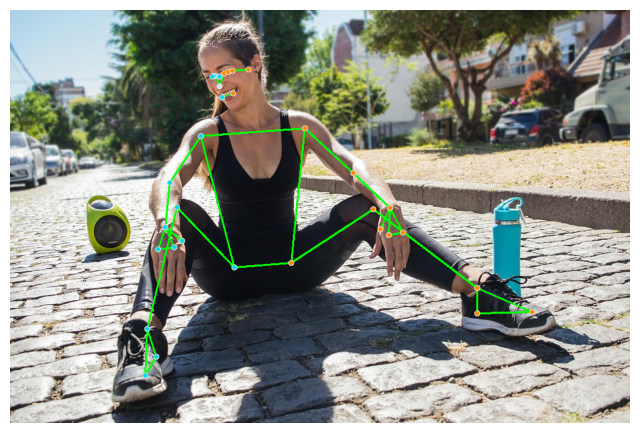

In [15]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.figure(figsize=(8, 6))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

Visualize the pose segmentation mask.

In [16]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
segmentation_mask = np.squeeze(segmentation_mask)

# Convert to 3‑channel uint8 image for visualization.
visualized_mask = (segmentation_mask * 255).astype(np.uint8)
visualized_mask = np.stack([visualized_mask]*3, axis=-1)

## Real-time webcam pose tracking (macOS)
Run the next cell and press `q` in the OpenCV window to stop.
If camera access is blocked, allow VS Code/Python in macOS Privacy & Security > Camera.

In [1]:
import time
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.vision import drawing_utils, drawing_styles


def draw_landmarks_on_image_rt(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks

    if rgb_image.ndim != 3:
        raise ValueError("Input image must be an HxWxC array")

    if rgb_image.shape[2] == 4:
        rgb_image = rgb_image[:, :, :3]
    elif rgb_image.shape[2] == 1:
        rgb_image = np.repeat(rgb_image, 3, axis=2)

    if rgb_image.shape[2] != 3:
        raise ValueError("Input image must have 3 channels after preprocessing")

    annotated_image_bgr = np.ascontiguousarray(rgb_image[:, :, ::-1])
    pose_landmark_style = drawing_styles.get_default_pose_landmarks_style()
    pose_connection_style = drawing_utils.DrawingSpec(color=(0, 255, 0), thickness=2)

    for pose_landmarks in pose_landmarks_list:
        drawing_utils.draw_landmarks(
            image=annotated_image_bgr,
            landmark_list=pose_landmarks,
            connections=vision.PoseLandmarksConnections.POSE_LANDMARKS,
            landmark_drawing_spec=pose_landmark_style,
            connection_drawing_spec=pose_connection_style,
        )

    return annotated_image_bgr[:, :, ::-1]


# Segmentation overlay settings
SEGMENTATION_THRESHOLD = 0.5
SEGMENTATION_ALPHA = 0.35
SEGMENTATION_COLOR_BGR = np.array([255, 120, 0], dtype=np.float32)  # blue tint

base_options_rt = python.BaseOptions(model_asset_path="pose_landmarker.task")
options_rt = vision.PoseLandmarkerOptions(
    base_options=base_options_rt,
    running_mode=vision.RunningMode.VIDEO,
    output_segmentation_masks=True,
)

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Could not open webcam. Check camera permissions and close other apps using the camera.")

print("Starting webcam pose tracking with segmentation. Press 'q' to quit.")

with vision.PoseLandmarker.create_from_options(options_rt) as detector_rt:
    while True:
        success, frame_bgr = cap.read()
        if not success:
            break

        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        timestamp_ms = int(time.time() * 1000)

        result_rt = detector_rt.detect_for_video(mp_frame, timestamp_ms)
        annotated_rgb = draw_landmarks_on_image_rt(frame_rgb, result_rt)
        annotated_bgr = cv2.cvtColor(annotated_rgb, cv2.COLOR_RGB2BGR)

        if result_rt.segmentation_masks:
            mask = result_rt.segmentation_masks[0].numpy_view()
            mask = np.squeeze(mask)
            if mask.shape[:2] != annotated_bgr.shape[:2]:
                mask = cv2.resize(mask, (annotated_bgr.shape[1], annotated_bgr.shape[0]))

            person_mask = mask > SEGMENTATION_THRESHOLD
            if np.any(person_mask):
                blended = annotated_bgr.astype(np.float32)
                blended[person_mask] = (
                    (1.0 - SEGMENTATION_ALPHA) * blended[person_mask]
                    + SEGMENTATION_ALPHA * SEGMENTATION_COLOR_BGR
                )
                annotated_bgr = blended.astype(np.uint8)

        cv2.imshow("Pose Landmarker + Segmentation (Press q to quit)", annotated_bgr)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

Starting webcam pose tracking with segmentation. Press 'q' to quit.


I0000 00:00:1771522576.324500 3126072 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1771522576.384737 3126074 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1771522576.444481 3126079 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1771522576.542190 3126076 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
